In [13]:
# lab 7 and 8
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from scipy import stats
import pickle
import math

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (12,7.5)
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

In [14]:
# import LHC data set 2:
higgs_file_in = open('higgs_100000_pt_1000_1200.pkl', 'rb')
higgs_data = pickle.load(higgs_file_in) # pandas DataFrame
print(type(higgs_data))
keys = higgs_data.keys()
print(keys)
qcd_file_in = open('qcd_100000_pt_1000_1200.pkl', 'rb')
qcd_data = pickle.load(qcd_file_in) # pandas DataFrame

<class 'pandas.core.frame.DataFrame'>
Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')


## Lab 7. 
Event selection optimization You and your lab partner should pick different pT (transverse momentum) samples for this lab. In each pT sample, there are dedicated training samples for event selection optimization. All studies should be carried out by normalizing Higgs and QCD samples in each pT sample to give expected yields accordingly (See Dataset descriptions).

#### 1. Make a stacked histogram plot for the feature variable: mass
* Evaluate expected significance without any event selection.
    * Use Poisson statistics for significance calculation

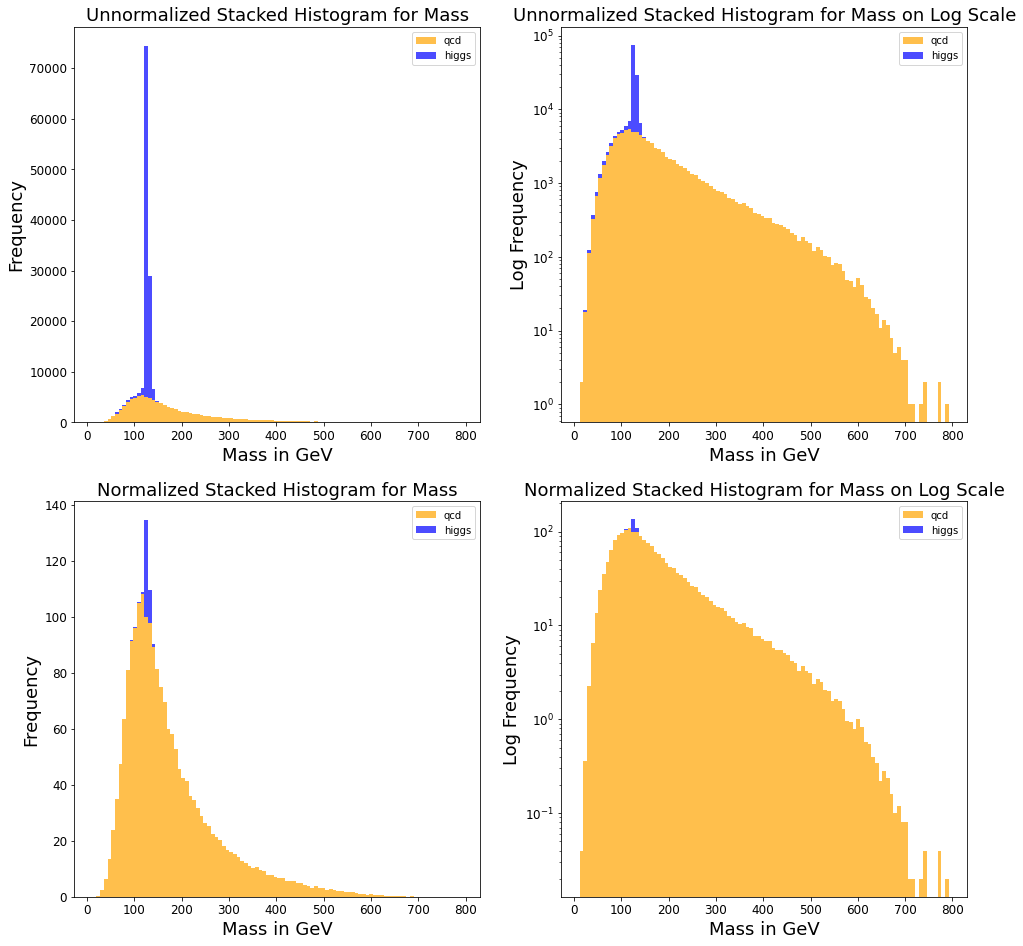

In [24]:
# stacked histogram plot for mass
# expected value of QCD: N_qcd = 2000
# expected value of higgs: N_higgs = 50
# the data has a million data points for both background and higgs, but in reality, there are much fewer higgs than background points, so we 
# manipulate the counts on the histogram by adjusting the weight of each data point in the higgs data set to the ratio 50/2000 or 0.025
# Note: setting density=True will not let you see the effect of the weight because density=True will cause the shape of the graph
# to still stay at total probability = 1
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

key = 'mass'
ax[0][0].hist((qcd_data[key], higgs_data[key]), bins=100, color=('orange', 'blue'), label=('qcd', 'higgs'), alpha=0.7, stacked=True)
ax[0][0].legend()
ax[0][0].set_title("Unnormalized Stacked Histogram for Mass", fontsize=18)
ax[0][0].set_xlabel('Mass in GeV', fontsize=18)
ax[0][0].set_ylabel('Frequency', fontsize=18)

ax[0][1].hist((qcd_data[key], higgs_data[key]), bins=100, color=('orange', 'blue'), label=('qcd', 'higgs'), alpha=0.7, stacked=True)
ax[0][1].legend()
ax[0][1].set_title("Unnormalized Stacked Histogram for Mass on Log Scale", fontsize=18)
ax[0][1].set_xlabel('Mass in GeV', fontsize=18)
ax[0][1].set_ylabel('Log Frequency', fontsize=18)
ax[0][1].set_yscale('log')

hist_weights_qcd = np.ones(int(1e5)) * 2000/100000
hist_weights_higgs = np.ones(int(1e5)) * 50/100000
ax[1][0].hist([qcd_data[key], higgs_data[key]], bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=[hist_weights_qcd, hist_weights_higgs], alpha=0.7, stacked=True)
ax[1][0].legend()
ax[1][0].set_title("Normalized Stacked Histogram for Mass", fontsize=18)
ax[1][0].set_xlabel('Mass in GeV', fontsize=18)
ax[1][0].set_ylabel('Frequency', fontsize=18)

ax[1][1].hist((qcd_data[key], higgs_data[key]), bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=(hist_weights_qcd, hist_weights_higgs), alpha=0.7, stacked=True)
ax[1][1].legend()
ax[1][1].set_title("Normalized Stacked Histogram for Mass on Log Scale", fontsize=18)
ax[1][1].set_xlabel('Mass in GeV', fontsize=18)
ax[1][1].set_ylabel('Log Frequency', fontsize=18)
ax[1][1].set_yscale('log')

In [21]:
# evaluation of expected significance
# Given that the background (QCD) is Poisson distributed with mu=2000, what is the probability of the background producing a 
# signal with >= 2050 events (2050 is the sum of the two expected values)? (significance is in terms of sigma on the normal distribution)
sig_2050 = abs(stats.norm.ppf(1 - stats.poisson.cdf(2050, mu=2000)))
print("Expected Significance = " + str(sig_2050))
print("Approximate Theoretical Significance = " + str(50/math.sqrt(2000)))

Expected Significance = 1.1282230087754428
Approximate Theoretical Significance = 1.118033988749895


#### 1. (continued)
* Compare the exact significance to the approximation  N_higgs/(√N_qcd). If they are equivalent, explain your findings.

The calculated or expected significance of the background producing the candidate signal of 2050 events is pretty close to the approximation. This is because of the relationship between Poisson distribution with high mean and the Gausssian distribution. At high mean, the Poisson distribution strongly resembles the standard normal distribution, so we can take advantage of the parameters and properties of both to arrive at this mathematical approximation. The z-score on the standard normal distribution, which is equivalent to the sigma value, has the formula (X - μ)/σ, where X is some value, μ is the expected value, and σ is the standard deviation. A Poisson distribution as expected value of μ and a standard deviation or spread of √μ. We are testing the probability of getting our candidate signal or something higher on the background QCD distribution that has expected value of μ = N_qcd. Let our candidate signal of 2050 be N_total. N_total = N_higgs + N_qcd, so N_higgs = N_total - N_qcd. Borrowing the formula for Z score on the Gaussian distribution, N_total = X (some value), N_qcd is our expected value μ, while σ for Poisson is √μ which is √N_qcd. Therefore, because Poisson with high expected value resembles a Gaussian distribution, N_higgs/(√N_qcd) is a good approximation for sigma.

#### 2. Identify mass cuts to optimize the expected significance.
* Try different mass cuts systematically
* Evaluate expected significance for each set of mass cuts
* Identify the set of mass cuts which give you the highest significance.